In [0]:
import os
import re
import datetime
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
def prepae_data():
    x, t = [], []

    categorized_dir_paths = glob('/content/drive/My Drive/kikagaku/novelapp/data/images/categorized-2/*')

    for dir_path in categorized_dir_paths:
        category_id = os.path.basename(dir_path)
        image_paths = glob(os.path.join(dir_path, '*'))
        print(datetime.datetime.now().isoformat(), 'Category', category_id, ':', len(image_paths))

        for i, p in enumerate(image_paths):
            book_id = re.sub(r'(_.*$)', '', os.path.basename(p))

            if i % 30 == 0:
                print(datetime.datetime.now().isoformat(), 'Image:', i, book_id, category_id)

            try:
                img = Image.open(p)
                img_resize = img.resize((229, 229))
                img_np = np.array(img_resize) / 255.0
                img_reshape = img_np.reshape(1, 229, 229, 3)
                #print(datetime.datetime.now().isoformat(), img_np.shape, img_reshape.shape)

                x.append(img_np)
                t.append(category_id)

            except Exception as e:
                print(datetime.datetime.now().isoformat(), 'Error:', e)

    return x, t

In [3]:
x, t = prepae_data()

2020-06-04T10:01:45.249121 Category 0 : 117
2020-06-04T10:01:45.249736 Image: 0 1015 0
2020-06-04T10:02:12.866451 Image: 30 1228 0
2020-06-04T10:02:36.835340 Image: 60 1106 0
2020-06-04T10:03:00.854075 Image: 90 1129 0
2020-06-04T10:03:23.965663 Category 1 : 119
2020-06-04T10:03:23.966334 Image: 0 3636 1
2020-06-04T10:03:47.632760 Image: 30 3722 1
2020-06-04T10:04:12.118976 Image: 60 3832 1
2020-06-04T10:04:36.828053 Image: 90 3777 1
2020-06-04T10:04:59.787013 Category 2 : 129
2020-06-04T10:04:59.787570 Image: 0 3601 2
2020-06-04T10:05:24.517365 Image: 30 3884 2
2020-06-04T10:05:48.942985 Image: 60 3778 2
2020-06-04T10:06:13.858962 Image: 90 3853 2
2020-06-04T10:06:38.623398 Image: 120 1502 2
2020-06-04T10:06:45.453023 Category 3 : 111
2020-06-04T10:06:45.453592 Image: 0 3312 3
2020-06-04T10:07:09.398363 Image: 30 2350 3
2020-06-04T10:07:34.421166 Image: 60 3010 3
2020-06-04T10:07:58.414109 Image: 90 3105 3


In [4]:
x = np.array(x).astype('f')
t = np.array(t).astype('f')
print(x.shape, t.shape)

(476, 229, 229, 3) (476,)


In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)

In [7]:
print(x_train.shape, x_val.shape)

(333, 229, 229, 3) (143, 229, 229, 3)


In [0]:
import os
import random

def reset_seed(seed=0):

    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [0]:
reset_seed(0)

In [10]:
category_count = len(np.unique(t))
print(np.unique(t))
print(category_count)

[0. 1. 2. 3.]
4


In [0]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=180,     # randomly rotate images in the range
    zoom_range=0.1,         # randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1, # randomly shift images vertically
    horizontal_flip=True,   # randomly flip images horizontally
    vertical_flip=True      # randomly flip images vertically
)

datagen.fit(x_train)

In [13]:
model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

for layer in model_fine.layers[:100]:
    layer.trainable = False


model = models.Sequential()
model.add(model_fine)

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
#model.add(layers.Dense(50, activation='relu'))
#model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(category_count, activation='softmax'))

optimizer = keras.optimizers.Adagrad(lr=0.005)
#optimizer = keras.optimizers.Adam(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

83689472/83683744 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 27,685,740
Trainable params: 16,101,900
Non

In [14]:
print(datetime.datetime.now().isoformat(), 'Start')

#history = model.fit(x_train, t_train,
#                    batch_size=30,
#                    epochs=400,
#                    verbose=0,
#                    validation_data=(x_val, t_val))
history = model.fit_generator(
    datagen.flow(x_train, t_train, batch_size=32),
    epochs=400,
    verbose=0,
    validation_data=(x_val, t_val),
    #steps_per_epoch=x_train.shape[0]
)

print(datetime.datetime.now().isoformat(), 'End')

2020-06-04T10:10:08.510217 Start
Instructions for updating:
Please use Model.fit, which supports generators.
2020-06-04T10:42:11.357848 End


In [0]:
results = pd.DataFrame(history.history)

In [16]:
results.head()

,loss,accuracy,val_loss,val_accuracy
0,7.831985,0.237237,1.564024,0.251748
1,1.413089,0.291291,1.381589,0.272727
2,1.398161,0.291291,1.384485,0.293706
3,1.353573,0.336336,1.386756,0.244755
4,1.377125,0.333333,1.387622,0.258741


In [17]:
results.tail()

,loss,accuracy,val_loss,val_accuracy
395,0.004239,1.000000,2.727381,0.538462
396,0.015021,0.993994,2.733625,0.545455
397,0.025298,0.993994,2.760044,0.559441
398,0.015331,0.996997,2.803598,0.538462
399,0.007864,0.996997,2.787699,0.545455


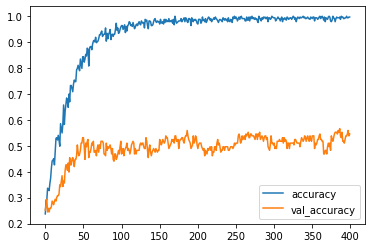

In [18]:
results[['accuracy', 'val_accuracy']].plot()

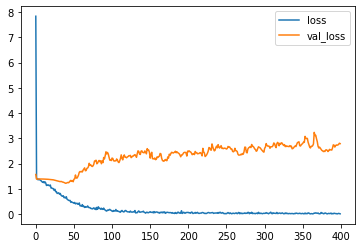

In [19]:
results[['loss', 'val_loss']].plot()